<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/preprocessing/DF_to_UVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hier wird mit Hilfe der vorverarebiteten Messdaten der UVI berechnet:

**Dokumentenname: DF_to_UVI.ipynb**

Es werden die vorverarbeiteten UV-Spektren in einen UVI und in die UVA und UVB Strahlung aggregiert. Zu Beginn muss das Skript *UV_Measurement_to_CSV* ausgeführt werden, um die Spektren in einen Dataframe umzuwandeln. Aufgrund der großen Datenmenge geschieht die Verarbeitung für jeden Monat getrennt.

## Import der benötigten Module:

In [ ]:
# Import der benötigten Module
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Mount der Google-Drive:

In [ ]:
# Mount google drive
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Monat der Exportiert werden sollen:**

22.06
22.07
22.08
22.09
22.10
22.11
22.12
23.01
23.02
23.03
23.04
23.05
23.06
23.07
23.08

In [ ]:
month = '22.09'

## Daten einlesen:

In [ ]:
# Import der CSV mit den rohen Messdaten
# Pfad zur CSV-Datei auf Google Drive
# Import:
folder_import = '/content/drive/My Drive/Colab_Notebooks/CSV_Messdaten/' + month

# Export:
folder_export = '/content/drive/My Drive/Colab_Notebooks/CSV_UVI'
folder_export_Gewichtet = '/content/drive/My Drive/Colab_Notebooks/CSV_Gewichtet'

# CSV-Datei einlesen und DataFrame erstellen
df_Messdaten = pd.read_csv(folder_import)

## Definetion der UV-Gewichtungsfunktion und UVA und UVB Bereich:

In [ ]:
# Gewichtungsfunktion für den UVI
def weight_function(Wellenlaenge):
    if Wellenlaenge <= 298:
        return 1
    elif Wellenlaenge > 298 and Wellenlaenge <= 328:
        return 10**(0.094 * (298.0 - Wellenlaenge))
    elif Wellenlaenge > 328 and Wellenlaenge <= 400:
        return 10**(0.015 * (139.0 - Wellenlaenge))
    else:
        return 0

In [ ]:
# Bereich von Spalte x bis Spalte y (einschließlich y)
x_UVI = '290.0'
y_UVI = '400.0'
selected_columns_UVI = df_Messdaten.columns[(df_Messdaten.columns.get_loc(x_UVI)):(df_Messdaten.columns.get_loc(y_UVI)+1)]

In [ ]:
# UVB Bereich von 290 bis 320.1 nm
x_UVB = '290.0'
y_UVB = '315.0'
selected_columns_UVA = df_Messdaten.columns[(df_Messdaten.columns.get_loc(x_UVB)):(df_Messdaten.columns.get_loc(y_UVB)+1)]

In [ ]:
# UVA Bereich von 320.1 bis 400 nm
x_UVA = '315.1'
y_UVA = '400.0'
selected_columns_UVB = df_Messdaten.columns[(df_Messdaten.columns.get_loc(x_UVA)):(df_Messdaten.columns.get_loc(y_UVA)+1)]

## Erythemgewichtete UV-Messwerte, UVI und UVA UVB bestimmen:

In [ ]:
# Erythemgewichtete UV-Messwerte
df_Gewichtet = []
df_Gewichtet = df_Messdaten[selected_columns_UVI].apply(lambda col: col * weight_function(float(col.name)), axis=0)

In [ ]:
def integrate_row(row):
    x_values = np.array([float(col) for col in row.index])  # X-Werte aus Spaltennamen extrahieren
    y_values = np.array(row)
    integral = np.trapz(y_values, x_values)
    return integral

In [ ]:
def calculate_UV_ABC(df):
    return df.sum(axis=1)

In [ ]:
# Summe der Messwerte über das UVA und UVB Spektrum
UVA = calculate_UV_ABC(df_Messdaten[selected_columns_UVA])
UVB = calculate_UV_ABC(df_Messdaten[selected_columns_UVB])
# Spalte umbenennen
UVA.name = 'UVA'
UVB.name = 'UVB'

In [ ]:
ser_UVI = []
df_UVI = []

# Integration der gewichteten UV-Messwerte
ser_UVI = df_Gewichtet.apply(integrate_row, axis=1)
# Umwandeln der Serie in einen Dataframe
df_UVI = pd.DataFrame(ser_UVI, columns=['erythem'])

In [ ]:
# Dem Dataframe die Werte für UVA und UVB hinzufügen
df_UV = pd.concat([df_UVI, UVA, UVB], axis=1)

In [ ]:
type(df_Gewichtet), type(df_UV)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

## Abspeichern der UVI, UVA, UVB Messwerte in einen Dataframe:

In [ ]:
# Exportieren

columns_to_copy = ['Datetime', 'Datum', 'Uhrzeit', 'Messzeitpunkt']

for col in columns_to_copy:
  df_Gewichtet.insert(0, col, df_Messdaten[col])
  df_UV.insert(0, col, df_Messdaten[col])
  df_UV['UVI'] = df_UV['erythem'].copy() * 40

In [ ]:
# Ändern der Reihenfolge der Spalten
# Aktuelle Spaltennamen
new_columns = ['Datetime','UVI','UVA','UVB','erythem','Datum','Uhrzeit','Messzeitpunkt']
df_UV = df_UV[new_columns]

In [ ]:
df_UV

,Datetime,UVI,UVA,UVB,erythem,Datum,Uhrzeit,Messzeitpunkt
0,2022-09-06 04:32:00,0.000933,0.000827,0.318351,0.000023,2022-09-06,04:32:00,16320
1,2022-09-06 04:34:00,0.001327,0.001296,0.425413,0.000033,2022-09-06,04:34:00,16440
2,2022-09-06 04:36:00,0.001715,0.001611,0.567706,0.000043,2022-09-06,04:36:00,16560
3,2022-09-06 04:38:00,0.002398,0.002375,0.745764,0.000060,2022-09-06,04:38:00,16680
4,2022-09-06 04:40:00,0.002964,0.002872,0.951027,0.000074,2022-09-06,04:40:00,16800
...,...,...,...,...,...,...,...,...
8250,2022-09-02 06:56:00,1.045392,1.300969,121.782089,0.026135,2022-09-02,06:56:00,24960
8251,2022-09-02 06:58:00,0.432583,0.243762,0.000000,0.010815,2022-09-02,06:58:00,25080
8252,2022-09-02 07:00:00,0.752765,1.328714,137.612769,0.018819,2022-09-02,07:00:00,25200
8253,2022-09-02 07:02:00,0.843798,1.487536,139.274483,0.021095,2022-09-02,07:02:00,25320


In [ ]:
def save_dataframe_to_drive(dataframe, folder_path, filename):

    # Erstelle den vollen Pfad zur Datei
    full_path = os.path.join(folder_path, filename)

    # Speichere den DataFrame als CSV-Datei auf Google Drive
    dataframe.to_csv(full_path, index=False)

    print(f'Der DataFrame wurde als {filename} in {folder_path} auf Google Drive gespeichert.')

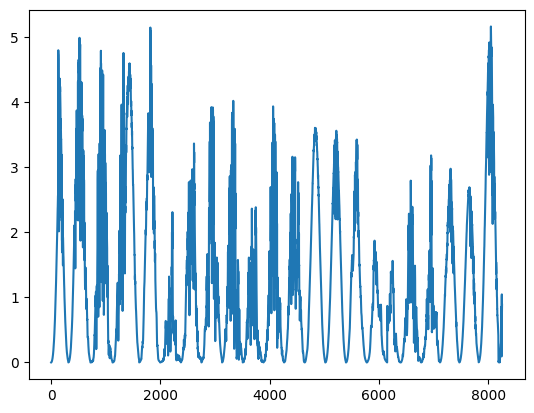

In [ ]:
plt.plot(df_UV['UVI'])

In [ ]:
save_dataframe_to_drive(df_UV, folder_export, month)

Der DataFrame wurde als 22.09 in /content/drive/My Drive/Colab_Notebooks/CSV_UVI auf Google Drive gespeichert.


In [ ]:
save_dataframe_to_drive(df_Gewichtet, folder_export_Gewichtet, month)

Der DataFrame wurde als 22.09 in /content/drive/My Drive/Colab_Notebooks/CSV_Gewichtet auf Google Drive gespeichert.
